In [211]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from utils import *

import numpy as np
import cvxopt

cvxopt.solvers.options['show_progress'] = False

%matplotlib inline

In [212]:
"""
Get the preprocessed data:
X and y are dicts, has keys train, val and test. keys gives you what word (or pair of words) each dimension corresponds to.

You can also get bigram features if you call preprocess(bigram = True)`
Another optional argument mincount specifies the frequency cutoff for inclusion of a word/bigram in the
dictionary.

"""

X, y, keys = preprocess()

Feature size:  1464


In [213]:
class Kernel(object):
    """
    A class containing all kinds of kernels.
    Note: the kernel should work for both input (Matrix, vector) and (vector, vector)
    """
    @staticmethod
    def linear():
        def f(x, y):
            return np.dot(x, y)
        return f

    @staticmethod
    def gaussian(gamma):  # we use the commonly used name, although it's not really a Gaussian
        def f(x, y):
            exponent = - gamma * np.linalg.norm((x-y).transpose(), 2, 0) ** 2
            return np.exp(exponent)
        return f

    @staticmethod
    def _poly(dimension, offset):
        def f(x, y):
            return (offset + np.dot(x, y)) ** dimension
        return f

    @staticmethod
    def inhomogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=1.0)

    @staticmethod
    def homogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=0.0)

    @staticmethod
    def hyperbolic_tangent(kappa, c):
        def f(x, y):
            return np.tanh(kappa * np.dot(x, y) + c)
        return f

In [229]:
class SVM(object):
    def __init__(self, kernel, c):
        """
        Build a SVM given kernel function and C

        Parameters
        ----------
        kernel : function
            a function takes input (Matrix, vector) or (vector, vector)
        c : a scalar
            balance term

        Returns
        -------
        """
        self._kernel = kernel
        self._c = c

    def fit(self, X, y):
        """
        Fit the model given data X and ground truth label y

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label

        Returns
        -------
        """
        # Solve the QP problem to get the multipliers
        lagrange_multipliers = self._compute_multipliers(X, y)
        # Get all the support vectors, support weights and bias
        self._construct_predictor(X, y, lagrange_multipliers)
    
    def predict(self, X):
        """
        Predict the label given data X

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)

        Returns
        -------
        y : 1D array
            predicted label
        """
        result = np.full(X.shape[0], self._bias) # allocate
        
        # YOUR CODE HERE

        length = len(self._weights)
        for i in range(length):
            result += self._weights[i] * self._support_vector_labels[i] * self._kernel(X, self._support_vectors[i])

        return np.sign(result)

    def _kernel_matrix(self, X):
        """
        Get the kernel matrix.

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)

        Returns
        -------
        K : 2D array
            N x N kernel matrix
        """
        N, d = X.shape
        K = np.zeros((N, N))
        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X):
                K[i, j] = self._kernel(x_i, x_j)
        return K

    def _construct_predictor(self, X, y, lagrange_multipliers):
        """
        Given the data, label and the multipliers, extract the support vectors and calculate the bias

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label
        lagrange_multipliers: 1D array
            the solution of lagrange_multiplier

        Fills in relevant variables: model bias and weights (alphas), and details of support vectors
        
        -------
        """
        support_vector_indices = \
            lagrange_multipliers > 1e-5
            
        print("SV number: ", np.sum(support_vector_indices))

        support_multipliers = lagrange_multipliers[support_vector_indices]
        support_vectors = X[support_vector_indices]
        support_vector_labels = y[support_vector_indices]

        """
        Get the bias term (w_0)
        """
        #YOUR CODE HERE

        length = len(support_multipliers)
        total_bias = 0.0
        count = 0
        bias = 0.0
        for k in range(length):
            # choose a support vector that is on a marginal hyperplane
            # support_multipliers[k] < 0.9*self._c and 1e-3 < support_multipliers[k]
            if support_multipliers[k] < 0.9 * self._c and support_multipliers[k] > 1e-3:
                # y_k is the label of your chosen support vector x_k
                y_k = support_vector_labels[k]
                # a_i (alpha_i) is the Lagrange multiplier for the i-th support vector
                a_i = support_multipliers
                # y_i is the label of the i-th support vector
                y_i = support_vector_labels
                # x_k is the k-th suport vector
                x = np.arange(len(lagrange_multipliers))[support_vector_indices]
                x_k = x[k]
                # x_i is the i-th support vector
                x_i = support_vector_indices
                # K(x_k, x_i) is the kernel function
                K = self._kernel_matrix(X)
                # add up total bias and count, make sure a_i > 0
                # bias is $w_0 = y_k - \sum_{\alpha_i > 0} (\alpha_i y_i K(x_k, x_i))$
                total_bias += (y_k - np.sum(np.maximum(a_i, 0) * y_i * K[x_k, x_i]))
                count += 1
                break
        # cannot divide by zero
        if count != 0:
            # computing an average bias term using multiple support vectors is also reasonable
            bias = total_bias / count

        self._bias=bias
        self._weights=support_multipliers
        self._support_vectors=support_vectors
        self._support_vector_labels=support_vector_labels

    def _compute_multipliers(self, X, y):
        """
        Given the data, label, solve the QP program to get lagrange multiplier.

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label

        Returns
        lagrange_multipliers: 1D array
        -------
        """
        N, d = X.shape

        K = self._kernel_matrix(X)
        """
        The standard QP solver formulation:
        min 1/2 x^T H x + f^T x
        s.t.
        Ax <=  a
        Bx = b
        """
        # $H_{ij} = y_i y_j K(x_i, x_j)$
        H = cvxopt.matrix(np.outer(y, y) * K)
        # f would correspond to a size N vector of negative ones
        f = cvxopt.matrix(-np.ones(N))

        # A is an NxN identity matrix
        A_upper = -np.eye(N)
        A_lower = np.eye(N)
        A = cvxopt.matrix(np.vstack((A_upper, A_lower)))
        # a is a size N vector of elements set to C
        a_upper = np.zeros(N)
        a_lower = np.ones(N) * self._c
        a = cvxopt.matrix(np.hstack((a_upper, a_lower)))

        # B is a vector with all elements equal to $y_i$ for all $i$ reshaped to size Nx1
        B = cvxopt.matrix(y.reshape(1, N))
        # b is a scalar equal to 0
        b = cvxopt.matrix(0.0)
        
        # call the QP solver
        solution = cvxopt.solvers.qp(H, f, A, a, B, b)

        # Lagrange multipliers (the unknown vector 'x' is our alphas)
        return np.ravel(solution['x'])

Test the trainer.
The following code would generate data which the grounth truth split is x+y = 0.5.

SV number:  8


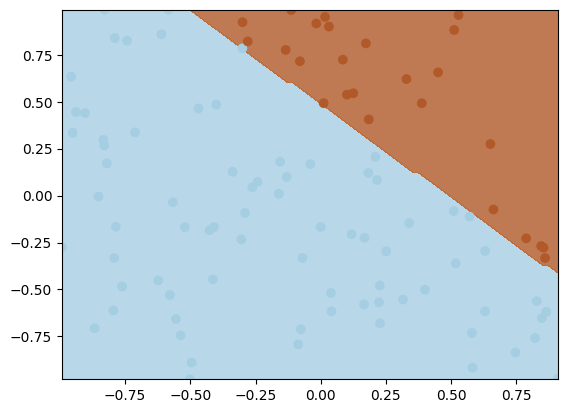

In [231]:
clf = SVM(Kernel.linear(), 100)
test_linear_SVM(clf, 100)

SV number:  12


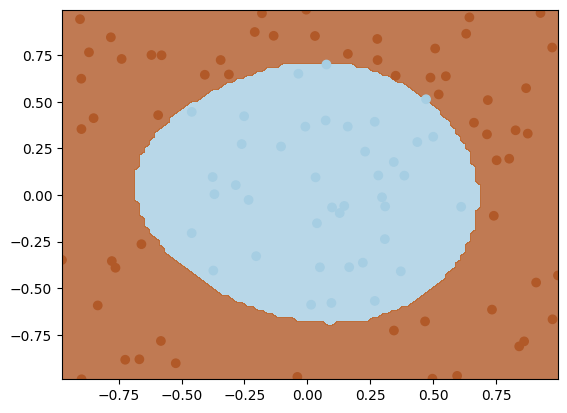

In [232]:
clf = SVM(Kernel.gaussian(1), 100)
test_rbf_SVM(clf, 100)

If you think your code is correct, then we can move to the real problem. Below are some code examples; you will need to fill in some details, and extend these to any experiments you want to run.

In [188]:
best_accuracy = 0
best_C = None

for C in [0.04, 0.05, 0.06]:
    clf = SVM(Kernel.linear(), C)
    clf.fit(X['train'], y['train'].astype('double'))
    print("C = ", C)
    y_hat = clf.predict(X['train'])
    print("Acc on train: ", np.mean(y_hat == y['train']))
    y_hat = clf.predict(X['val'])
    acc_val = np.mean(y_hat == y['val'])
    print("Acc on val: ", acc_val)

    if acc_val > best_accuracy:
        best_accuracy = acc_val
        best_C = C

SV number:  1834
C =  0.04
Acc on train:  0.8410237923576064
Acc on val:  0.734
SV number:  1785
C =  0.05
Acc on train:  0.8525594808940159
Acc on val:  0.744
SV number:  1750
C =  0.06
Acc on train:  0.8640951694304254
Acc on val:  0.748


Choose the best C, and predict the label for test data.

In [189]:
C = best_C
clf = SVM(Kernel.linear(), C)
clf.fit(X['train'], y['train'].astype('double'))
y_hat = clf.predict(X['test'])
save_submission('sub_linear.csv', y_hat)


SV number:  1750


RBF (Gaussian) kernel SVM

In [183]:
best_accuracy = 0
best_C = None
best_gamma = None

for C in [10.0]:
    for gamma in [0.1]:
        clf = SVM(Kernel.gaussian(gamma), C)
        clf.fit(X['train'], y['train'].astype('double'))
        print("C = ", C)
        print("gamma = ", gamma)
        y_hat = clf.predict(X['train'])
        print("Acc on train: ", np.mean(y_hat == y['train']))
        y_hat = clf.predict(X['val'])
        acc_val = np.mean(y_hat == y['val'])
        print("Acc on val: ", acc_val)

        if acc_val > best_accuracy:
            best_accuracy = acc_val
            best_C = C
            best_gamma = gamma
        

SV number:  2417
C =  10.0
gamma =  0.1
Acc on train:  1.0
Acc on val:  0.762


In [184]:
clf = SVM(Kernel.gaussian(best_gamma), best_C)
clf.fit(X['train'], y['train'].astype('double'))
y_hat = clf.predict(X['test'])
save_submission('sub_rbf.csv', y_hat)


SV number:  2417
